In [2]:
%load_ext rqalpha

         when using: `python -m better_exceptions'. Otherwise, only code
         loaded from files will be inspected!


2017-01-03 INFO init
2017-01-03 INFO Remaning cash: 100000.0


2017-01-04 INFO Remaning cash: 80814.664000000004
2017-01-05 INFO Remaning cash: 100093.89880000001
2017-01-06 INFO Remaning cash: 100093.89880000001
2017-01-09 INFO Remaning cash: 100093.89880000001
2017-01-10 INFO Remaning cash: 100093.89880000001
2017-01-11 INFO Remaning cash: 100093.89880000001
2017-01-12 INFO Remaning cash: 100093.89880000001
2017-01-13 INFO Remaning cash: 100093.89880000001
2017-01-16 INFO Remaning cash: 80239.027600000016
2017-01-17 INFO Remaning cash: 60560.297200000015
2017-01-18 INFO Remaning cash: 41040.694000000018
2017-01-19 INFO Remaning cash: 21627.175600000017
2017-01-20 INFO Remaning cash: 2225.6668000000172
2017-01-23 INFO Remaning cash: 24.666800000017247
2017-01-24 INFO Remaning cash: 24.666800000017247
2017-01-25 INFO Remaning cash: 0.021200000017415732
2017-01-26 INFO Remaning cash: 881.09960000001956
2017-02-03 INFO Remaning cash: 1407.7130000000179
2017-02-06 INFO Remaning cash: 277.71300000001793
2017-02-07 INFO Remaning cash: 277.7130000000179

2017-09-04 INFO Remaning cash: 848.28340000001845
2017-09-05 INFO Remaning cash: 848.28340000001845
2017-09-06 INFO Remaning cash: 848.28340000001845
2017-09-07 INFO Remaning cash: 848.28340000001845
2017-09-08 INFO Remaning cash: 848.28340000001845
2017-09-11 INFO Remaning cash: 848.28340000001845
2017-09-12 INFO Remaning cash: 848.28340000001845
2017-09-13 INFO Remaning cash: 848.28340000001845
2017-09-14 INFO Remaning cash: 163.28340000001845
2017-09-15 INFO Remaning cash: 163.28340000001845
2017-09-18 INFO Remaning cash: 163.28340000001845
2017-09-19 INFO Remaning cash: 163.28340000001845
2017-09-20 INFO Remaning cash: 163.28340000001845
2017-09-21 INFO Remaning cash: 163.28340000001845
2017-09-22 INFO Remaning cash: 163.28340000001845
2017-09-25 INFO Remaning cash: 163.28340000001845
2017-09-26 INFO Remaning cash: 163.28340000001845
2017-09-27 INFO Remaning cash: 163.28340000001845
2017-09-28 INFO Remaning cash: 163.28340000001845
2017-09-29 INFO Remaning cash: 163.28340000001845


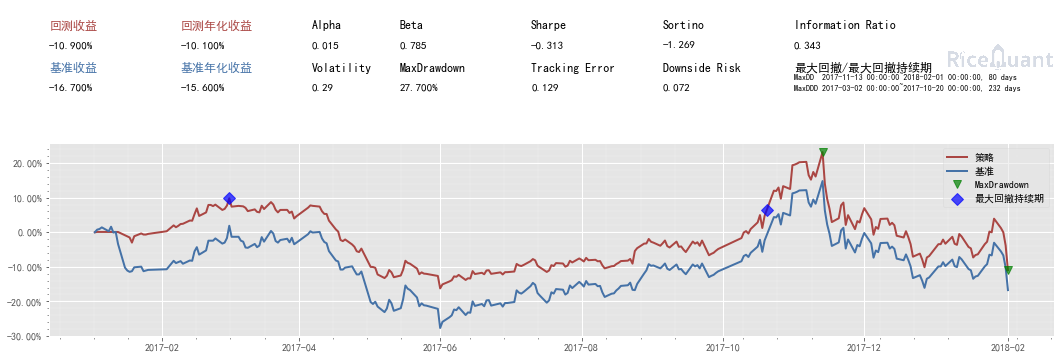

In [149]:
%%rqalpha -s 20170101 -e 20180201 -p -bm 600651.XSHG --account stock 100000 -o C:/wendou/test.pkl --progress

import numpy as np
import pandas as pd
from math import log



def meb(x, a, b, c):
    # return the membership of PL,PM,PS,AZ,NS,NM,NL
    # x is return , a, b, c is the boundary of the membership
    if x <= a:
        return 0.0
    if (x > a) and (x <= b):
        return (x - a) / (b - a)
    if (x > b) and (x <= c):
        return (c - x) / (c - b)
    if x > c:
        return 0.0
    if a == b:
        if x <= b:
            return 1.0
        if (x > b) and (x <= c):
            return (c - x) / (c - b)
        if x > c:
            return 0.0
    if b == c:
        if x <= a:
            return 0.0
        if (x > a) and (x <= b):
            return (x - a) / (b - a)
        if x > b:
            return 1.0

def risk_control(context):
    # control the portfolio risk
    pass

def stock_selection(context):
    # select the stock
    pass
        
def exposure_control(context):
    # control the exposure
    pass

def log_cash(context, bar_dict):
    logger.info("Remaning cash: %r" % context.portfolio.cash, context.portfolio.positions)

    
def init(context):
    logger.info("init")
    context.s1 = "002032.XSHE"
    # if instruments(context.s1).days_from_listed(date=None)<366:
    # os._exit()
    scheduler.run_daily(log_cash)
    context.portfolios=[ '600653.XSHG', '600651.XSHG']
    multidx=pd.MultiIndex.from_product([context.portfolios,[0,1]])
    update_universe(context.s1)
    # 是否已发送了order
    context.fired = False
    context.P = np.matrix('10 0;0 10')
    context.Ppanel = pd.Panel(np.zeros([len(context.portfolios),2,2]),items=context.portfolios)

    for value in context.portfolios:
        context.Ppanel[value]=context.P
    context.c = 0.01
    context.lmd = 0.9

    context.aa = pd.DataFrame(np.zeros([1, multidx.size]), columns=multidx)
    context.aadataframe = pd.DataFrame(np.zeros([1,multidx.size]),columns=multidx)
    #context.aapanel = pd.Panel(np.zeros([4,1,2]),items=context.portfolios, minor_axis=[0,1])
    # print(aa)
    # context.c = 0.01
    for value in context.portfolios:
        context.value=False #record the order is fired or not

def before_trading(context):
    c = context.c
    lmd = context.lmd
    #P = context.P
    
    
    for value in context.portfolios:
        P = np.matrix(context.Ppanel[value])
        #aa = context.aapanel[value].tail(1)
        aa = context.aa[[value]]
        aai = np.matrix(aa).T
        try:
            numerator = history_bars(value, 1, '1d', 'close').mean()
            denominator = history_bars(value, 5, '1d', 'close').mean()
            tmp = history_bars(value, 2, '1d', 'close')
            r = log(tmp[1] / tmp[0])
            avg_return = log(numerator / denominator)
            y1 = meb(avg_return, 0, c, 2 * c)
            y2 = meb(avg_return, c, 2 * c, 3 * c)
            y3 = meb(avg_return, 2 * c, 3 * c, 3 * c)
            y4 = meb(avg_return, -2 * c, -c, 0)
            y5 = meb(avg_return, -3 * c, -2 * c, -c)
            y6 = meb(avg_return, -3 * c, -3 * c, -2 * c)
            y7 = meb(avg_return, -c, 0, c)
            ya = y1 + y2 + y3 + y7
            yb = y4 + y5 + y6 + y7
            # print(ya,yb)
            if ya == 0:
                ed6 = 0
            else:
                ed6 = (0.1 * y1 + 0.2 * y2 + 0.4 * y3) / ya
            if yb == 0:
                ed7 = 0
            else:
                ed7 = (0.1 * y4 + 0.2 * y5 + 0.4 * y6) / yb
        # print(ed6,ed7)
            X = np.matrix([[ed6], [ed7]])
            K = P * X / (X.T * P * X - lmd)
            aat = (aai + K * (r - X.T * aai)).T
            #context.P = (P - K * X.T * P) / lmd
            context.Ppanel[value]=(P - K * X.T * P) / lmd
            #print(context.aapanel[value].values)
            context.aa[[value]]=aat
            #print (aat)
            #context.aapanel.update(context.aapanel[value].append(pd.DataFrame(aat), ignore_index=True))
            # context.aapanel[value] = context.aapanel[value].append(pd.DataFrame(aat), ignore_index=True)
            #context.aa = context.aa.append(pd.DataFrame(aat), ignore_index=True)
        except:
            print("Error when trying")
        # print(tmp)
    context.aadataframe = context.aadataframe.append(context.aa)
    #print(context.aadataframe)

# 你选择的证券的数据更新将会触发此段逻辑，例如日或分钟历史数据切片或者是实时数据切片更新
def handle_bar(context, bar_dict):
    # 开始编写你的主要的算法逻辑
    #print(context.aapanel.values)
    # bar_dict[order_book_id] 可以拿到某个证券的bar信息
    # context.portfolio 可以拿到现在的投资组合状态信息
    aaa = context.aadataframe.tail(3)
    a = context.aadataframe.tail(1)
    for value in context.portfolios:
        price_nextday = history_bars(value, 1, '1d', 'close')  
        #if context.value==True:
            #print(price_nextday)
            #order_percent(value, -1)
            #context.value==False
    
        #upcondition = aaa[value].iloc[:,0]>0
        #dncondition = a[value].iloc[:,1]>0
        #if all(upcondition):
        if aaa[value].iloc[:,0].sum()>aaa[value].iloc[:,1].sum():
            #logger.info(price_nextday)
            order_percent(value, 0.2)
            context.value=True
        else:
        #if all(dncondition):
            order_percent(value, -0.2)

    # 使用order_shares(id_or_ins, amount)方法进行落单
    # TODO: 开始编写你的算法吧！
    #aa = context.aa.tail(1)
    #if aa.iloc[0, 0] > 0:
        # order_percent并且传入1代表买入该股票并且使其占有投资组合的100%
    #order_percent(000005.XSHE, 0.2)
        # context.fired = True
    #else:
        #order_percent(context.s1, -0.5)

In [140]:
import pandas as pd
result = pd.read_pickle('C:/wendou/test.pkl')
result.keys()
result['trades']

dict_keys(['summary', 'trades', 'portfolio', 'benchmark_portfolio', 'stock_account', 'stock_positions'])

In [147]:
aadataframe

NameError: name 'aadataframe' is not defined